# Reshape datasets for training




In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

## Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [2]:
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')

In [3]:
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')

Its datatype is `xarray.Dataset`, containing a spatio-temporal subset of 5 variables that we selected from the original ERA5 dataset. It also contains one derived variable (`rtp_500-850`) that is used in Meteorology quite a bit because it is proportional to mass-weighted mean temperature of the air, in this case between 850 and 500 hPa. It could be an additional predictor to classify the weather regime.

### Selecting useful predictor variables
The selection has already been done by us when preparing the small sample datasets for you, so you can use them straight away. What is still necessary, is clustering and reshaping the input data dimension, because the dimensionality of the raw input data would be too high: 

To give a rough estimate, imagine using all GloFAS and ERA5 gridpoints of the upstream area of one point. For 1.5x1.5  degree (lat,lon), ERA5 provides 6 x 6 and GloFAS 15 x 15 gridpoints. To take the time dimension into account we'd need, say, 10 days of discharge and 180 days of precipitation. 

Summing up, this makes the raw input dimensionality 15 x 15 x 10 and 6 x 6 x 180, in total ~8700 features, where most of the predictors won't vary that much from one gridpoint to another in the upstream area (large scale temperature, total-column water vapor).

To work around that, we need to 
  1. spatially aggregate  and 
  2. temporally aggregate the data (reduce dimensionality). 
  
Both will be done in sections below, but first we need to define which point we will be making forecasts for.

### Selecting the predictand
The target variable shall be the discharge at the point where the Danube river leaves the data domain. This is given by the point within the catchment where the discharge is the highest, so we first filter by the catchment basin shapefile (Worldbank dataset "Global River Basins")

To select the basin from the shapefile, we use a function defined in `./aux/utils.py`. The interested user may have a look there how it is done, but it would obstruct the clarity in this notebook. To import the function it needs to be present in the current processes path. We do that by adding the parent/main directory to `sys.path`. In this way we can import some function in `./aux/utils_flowmodel.py` by `from aux.utils_flowmodel import somefunction`.

In [4]:
import sys
sys.path.append("../../")
from python.aux.utils_floodmodel import get_mask_of_basin, add_shifted_variables

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


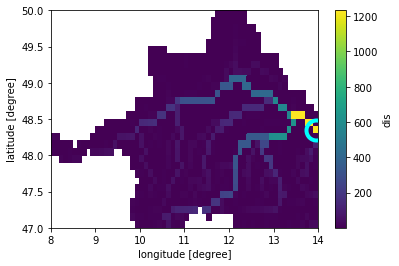

In [5]:
dis_mean = glofas['dis'].mean('time')
danube_catchment = get_mask_of_basin(dis_mean)
dis = glofas['dis'].where(danube_catchment)

maximum = dis.where(dis==dis.max(), drop=True)
lat, lon = float(maximum.latitude), float(maximum.longitude)

dis.mean('time').plot()
plt.gca().plot(lon, lat, color='cyan', marker='o', 
               markersize=20, mew=4, markerfacecolor='none')

### Spatial aggregation
We can either take the total sum of precipitation that falls throughout the basin, or we can aggregate it by time to the point of interest (POI). As we can see from the discharge plot above, points with less mean discharge are further away from the POI compared to gridpoints with a lighter color. This is the motivation to cluster the precipitation points by the mean discharge of the gridpoint. So we need discharge bins, according to which the precipitation at these gridpoints is grouped together to form one feature/predictor. The bin size can be determined from the distribution of discharges, so that points above 200 m^3/s discharge are one cluster, points from 100-200 m^3/s another cluster and so on.

We'd like to have bins with equal 'flow time' to the POI. 
For 4 equal bins, use percentiles 0.25, 0.5 and 0.75.

We see that 80 percent of all gridpoints exhibit a mean discharge of less than 20 m^3/s, and that there is a sharp edge between 5 and 10 m^3/s discharge.

In [6]:
bins = [0, 0.8, 2.4, 10.25, 10000]

dis_mean = dis.mean('time')
cluster = dict()
for i in range(len(bins)-1):
    cluster[str(i)] = (dis_mean >= bins[i]) & (dis_mean < bins[i+1])
    cluster[str(i)].attrs['units'] = None
    
cluster = xr.Dataset(cluster, coords=dict(clusterId=('clusterId', range(len(bins))),
                                          latitude=('latitude', dis_mean.latitude),
                                          longitude=('longitude', dis_mean.longitude)))
cluster = cluster.to_array('clusterId')

In [7]:
from python.aux.utils_floodmodel import shift_and_aggregate, aggregate_clustersum

In [8]:
shifts = [1, 2, 3]
shift_vars = ['lsp'] 

Xs = add_shifted_variables(era5, shifts, variables=shift_vars)

In [9]:
Xs['lsp-4-10'] = shift_and_aggregate(Xs['lsp'], shift=4, aggregate=7)
Xs['lsp-11-24'] = shift_and_aggregate(Xs['lsp'], shift=14, aggregate=14)
Xs['lsp-25-54'] = shift_and_aggregate(Xs['lsp'], shift=28, aggregate=30)
Xs['lsp-55-180'] = shift_and_aggregate(Xs['lsp'], shift=55, aggregate=126)

In [10]:
X = Xs.interp(latitude=glofas.latitude, longitude=glofas.longitude)

In [11]:
Xagg = aggregate_clustersum(X, cluster, 'clusterId')
Xagg

<xarray.Dataset>
Dimensions:               (time: 5478)
Coordinates:
  * time                  (time) datetime64[ns] 1981-01-01 ... 1995-12-31
Data variables:
    cp_cluster0           (time) float64 5.482e+07 1.906e+07 ... 0.0 7.634e+05
    cp_cluster1           (time) float64 6.716e+07 2.49e+07 ... 5.396e+05
    cp_cluster2           (time) float64 1.021e+08 3.952e+07 ... 1.192e+06
    cp_cluster3           (time) float64 8.35e+07 3.462e+07 ... 5.767e+05
    lsp_cluster0          (time) float64 4.996e+07 2.12e+08 ... 1.25e+06
    lsp_cluster1          (time) float64 7.006e+07 2.711e+08 ... 1.295e+07
    lsp_cluster2          (time) float64 1.308e+08 4.153e+08 ... 5.657e+07
    lsp_cluster3          (time) float64 8.867e+07 3.254e+08 ... 2.891e+07
    swvl1_cluster0        (time) float64 8.579e+09 8.594e+09 ... 8.445e+09
    swvl1_cluster1        (time) float64 9.507e+09 9.498e+09 ... 9.414e+09
    swvl1_cluster2        (time) float64 1.195e+10 1.192e+10 ... 1.203e+10
    swvl1_cluste

In [13]:
y = glofas['dis'].interp(latitude=lat, longitude=lon)
y

<xarray.DataArray 'dis' (time: 5478)>
array([798.361572, 792.207703, 796.706116, ..., 783.30896 , 782.144958,
       778.828003])
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude   float64 48.35
    longitude  float64 13.95
Attributes:
    long_name:  discharge
    units:      m3/s

## The reshaping procedure




In [22]:
def reshape_scalar_predictand(X_dis, y):
    """Reshape, merge predictor/predictand in time, drop nans.
    Parameters
    ----------
        X_dis : xr.Dataset
            variables: time shifted predictors (name irrelevant)
            coords: time, latitude, longitude
        y : xr.DataArray
            coords: time
    """
    if isinstance(X_dis, xr.Dataset):
        X_dis = X_dis.to_array(dim='var_dimension')

    # stack -> seen as one dimension for the model
    stack_dims = [a for a in X_dis.dims if a != 'time']  # all except time
    X_dis = X_dis.stack(features=stack_dims)
    Xar = X_dis.dropna('features', how='all')  # drop features that only contain NaN

    # to be sure that these dims are not in the output
    for coord in ['latitude', 'longitude']:
        if coord in y.coords:
            y = y.drop(coord)

    # merge times
    y.coords['features'] = 'predictand'
    Xy = xr.concat([Xar, y], dim='features')  # maybe merge instead concat?
    Xyt = Xy.dropna('time', how='any')  # drop rows with nan values

    Xda = Xyt[:, :-1]  # last column is predictand
    yda = Xyt[:, -1].drop('features')  # features was only needed in merge
    return Xda, yda

This function is available from here:

`from python.aux.utils_flowmodel import reshape_scalar_predictand`


In [23]:
Xda, yda = reshape_scalar_predictand(Xagg, y)

In [25]:
Xda.shape, yda.shape

((5134, 52), (5134,))